In [ ]:
!pip install plotly

In [61]:
!pip uninstall -y numpy
!pip install numpy

Found existing installation: numpy 1.16.6
Uninstalling numpy-1.16.6:
  Successfully uninstalled numpy-1.16.6
     |████████████████████████████████| 15.7 MB 1.7 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorlayer 2.1.0 requires numpy<1.17,>=1.16, but you have numpy 1.21.4 which is incompatible.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow 2.4.1 requires wrapt~=1.12.1, but you have wrapt 1.11.1 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import math
import time
from functools import partial

import plotly.express as px

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.callbacks as cb

from sklearn.model_selection import train_test_split

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
np.random.seed(2021)
tf.random.set_seed(2021)

In [4]:
num_classes=10

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train_1hot = keras.utils.to_categorical(y_train, num_classes)
y_test_1hot = keras.utils.to_categorical(y_test, num_classes)

In [5]:
batch_size = 128
meta_batch_size = 32
epochs = 10
plt_x,plt_y=x_test[:batch_size],y_test[:batch_size]

In [6]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train,y_train))
all_class_list=[train_loader.filter(lambda x,y: y==yy)
                  .cache()
                  .shuffle(2000)
                  .prefetch(50)
                 for yy in range(num_classes)]

In [7]:
WAYS=5
SHOTS=3
W,H,CH=28,28,1

In [8]:
def form_meta2(dataset_list,mult=4):
    orders=np.concatenate([np.random.permutation(len(dataset_list)) for x in range(mult)])
    for tasks in range(len(orders)//WAYS):
        #從已決定好的順序拉出WAY個class#
        picked=[dataset_list[tt] for tt in orders[WAYS*tasks:WAYS*(tasks+1)]]
        #每個class抽SHOTS+1張#
        data = [next(iter(class_loader.batch(SHOTS+1)))[0] for class_loader in picked]
        #support每個class各有SHOTS張照片#
        support=tf.concat([d[:-1] for d in data],axis=0)
        #query挑每個class 1 張，順序不固定#
        idxs=np.random.choice(range(WAYS), size=WAYS, replace=False)
        query=tf.concat([data[wayid][-2:-1] for wayid in idxs],axis=0)
        #輸出的時候把support跟query接在一起#
        yield tf.concat([support, query], axis=0), tf.stack([keras.utils.to_categorical(idx,num_classes=WAYS) for idx in idxs], axis=0)

In [10]:
MULT=400
train_meta_loader=tf.data.Dataset.from_generator(partial(form_meta2,all_class_list,MULT),
                                                 output_types=(tf.float32,tf.float32),
                                                output_shapes=((WAYS*(SHOTS+1),W,H,CH),(WAYS,WAYS)))

In [11]:
start_time=time.time()
for ld in all_class_list:
    for xx,yy in ld.batch(500):
        pass
print(f"{time.time()-start_time:.03f} sec")

15.230 sec


In [12]:
start_time=time.time()
for ld in all_class_list:
    for xx,yy in ld.batch(500):
        pass
print(f"{time.time()-start_time:.03f} sec")

2.557 sec


In [13]:
## Embedding ##
class Encoder(keras.Model):
    def __init__(self,n_layers=2,latent_features=2,hidden_featrues=64):
        super().__init__()
        self.latent_features=latent_features
        # First Layer
        self.conv_0=keras.layers.Conv2D(hidden_featrues, kernel_size=3, activation="relu",padding='same')
        self.dropout_0=keras.layers.Dropout(0.2)
        # Middle Layers
        self.convs=[keras.layers.Conv2D(hidden_featrues, kernel_size=3, activation="relu",padding='same') for _ in range(n_layers)]
        self.mxpools = [keras.layers.MaxPooling2D(pool_size=2) for _ in range(n_layers)]
        self.dropouts = [keras.layers.Dropout(0.2) for _ in range(n_layers)]
        # Integration Layer(Output Layer)
        WIDTH=2
        self.gap=keras.layers.AveragePooling2D(pool_size=WIDTH,)
        self.flatten=keras.layers.Flatten()
        self.dense=keras.layers.Dense(latent_features)
      
    def call(self,x):
        x=self.dropout_0(self.conv_0(x))
        for conv,mxp,drp in zip(self.convs,self.mxpools,self.dropouts):
            x=drp(mxp(conv(x)))
        x=self.gap(x)
        x=self.flatten(x)
        y=self.dense(x)
        return y

## Special Layers ##

class MatMul:
    def __init__(self,mode="paired"):
        self.mode=mode
        assert mode in ["paired","cross"]
    def __call__(self,q,s):
        if self.mode=="paired":
            return tf.reduce_sum(tf.multiply(q,s),axis=-1,keepdims=True)
        if self.mode=="cross":
            return tf.matmul(q,s,transpose_b=True)
        
class EuclideanDist:
    def __init__(self,mode="paired"):
        self.mode=mode
        assert mode in ["paired","cross"]
        
    def __call__(self,q,s):
        if self.mode=="paired":
            dist=tf.math.reduce_euclidean_norm(q-s,axis=-1,keepdims=True)
        if self.mode=="cross":
            dist=-tf.math.reduce_euclidean_norm(
                tf.stack([q[:,qq:qq+1]-s for qq in range(q.shape[1])],axis=1)
                ,axis=-1,keepdims=False)
            
        return dist

class CosSim:
    def __init__(self,mode="paired"):
        self.mode=mode
        assert mode in ["paired","cross"]
        self.matmul=MatMul(mode)
    def __call__(self,q,s):
        query_n=tf.math.l2_normalize(q, axis=-1)
        support_n=tf.math.l2_normalize(s, axis=-1)
        return self.matmul(query_n,support_n)
    
class CosineLayer(keras.layers.Layer):
    def __init__(self, out_features=10,mode="cross"):
        super().__init__()
        self.out_features = out_features
        self.cos_sim=CosSim(mode)
    def build(self, input_shape):
        self.w = self.add_weight(shape=(self.out_features,input_shape[-1]),
                               initializer='glorot_uniform',
                               trainable=True)
    def call(self, inputs):
        return self.cos_sim(inputs,self.w)

## Loss function ##
class ContrastiveLoss:
    def __init__(self,m=1,mode="dist"):
        
        self.mode=mode
        if self.mode=="dist":
            self.m=m
        if self.mode=="cos" or self.mode=="matmul":
            self.activation=keras.activations.sigmoid
            self.loss_fn=keras.losses.BinaryCrossentropy()
        assert mode in ["dist","cos","matmul"]
        self.__name__="loss"
    def __call__(self,y_true, y_pred):
        if self.mode=="dist":
            loss=tf.reduce_mean(y_true * tf.square(y_pred) +
                                 (1 - y_true)* tf.square(tf.maximum(self.m - y_pred, 0)),
                               axis=-1,keepdims=True)
        if self.mode=="cos" or self.mode=="matmul":
            loss=self.loss_fn(y_true,self.activation(y_pred))
        return loss
    
class FocalLoss:
    def __init__(self, gamma=3, eps=1e-10):
        self.gamma = gamma
        self.eps = tf.constant(eps)
        self.cce=keras.losses.CategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
        self.__name__="loss"
    def __call__(self,y_true, y_pred):
        logp = self.cce(y_true,y_pred)
        p = tf.exp(-logp)
        loss = (tf.constant(1.) - p) ** self.gamma * logp
        return tf.reduce_mean(loss, axis=-1)
    
class AddMarginLoss():
    def __init__(self,s=5,m=0.3,gamma=3):
        self.s = s
        self.m = m
        self.lossfn=FocalLoss(gamma)
        self.__name__="loss"
    def __call__(self, y_true, y_pred):
        cosine=y_pred
        phi = cosine - self.m
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        arc = (y_true * phi) + ((1.0 - y_true) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        arc *= self.s
        return self.lossfn(y_true,arc)
    
class ArcMarginLoss():
    def __init__(self,s=32,m=0.3,easy_margin=False,gamma=3, eps=1e-6):
        self.s = s
        self.m = m
        self.eps=tf.constant(eps)# This is very, very, very important
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        
        self.lossfn=FocalLoss(gamma)
        self.__name__="loss"
    def __call__(self, y_true, y_pred):
        cosine=y_pred
        
        sine = tf.sqrt(tf.constant(1.) - tf.pow(cosine, 2) + self.eps)
        
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where((cosine - self.th) > 0, phi, cosine - self.mm)
        
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        arc = (y_true * phi) + ((1.0 - y_true) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        arc *= self.s
        return self.lossfn(y_true,arc)
    
## Main Model ##
class ClassModel(keras.Model):
    def __init__(self,encoder,out_features=10,mode="dense"):
        super().__init__()
        assert mode in ["dense","cosmargin","arcmargin"]
        self.encoder=encoder
        self.mode=mode
        self.latent_features=encoder.latent_features
        
        if self.mode=="dense":
            self.output_layer=keras.layers.Dense(out_features,use_bias=False)
            self.loss_fn=FocalLoss(3)
            return
        
        self.output_layer=CosineLayer(out_features)
        if self.mode=="cosmargin":
            self.loss_fn=AddMarginLoss(s=5,m=0.3)
        if self.mode=="arcmargin":
            self.loss_fn=ArcMarginLoss(s=5,m=0.4,easy_margin=False)
        
    def call(self,x,training=False):
        latent=self.encoder(x)
        return self.output_layer(latent)

class SiameseModel(keras.Model):
    # Mode: dist= euclidean distance
    #       cos = cosine distance
    #       matmult= matric multiplication distance
    def __init__(self,encoder,mode="cos"):
        super().__init__()
        assert mode in ["dist","cos","matmul"]
        self.encoder=encoder
        self.mode=mode
        self.latent_features=encoder.latent_features
        if self.mode=="dist":
            self.matric_fn=EuclideanDist("paired")
        if self.mode=="cos":
            self.matric_fn=CosSim("paired")
        if self.mode=="matmul":
            self.matric_fn=MatMul("paired")
        self.loss_fn=ContrastiveLoss(1,mode=mode)
            
    def call(self,x,training=False):
        latent_s=self.encoder(x[:,0])
        latent_q=self.encoder(x[:,1])

        return self.matric_fn(latent_q,latent_s)     
  
    
class PrototypicalNetworks(keras.Model):
    # Mode: dist= euclidean distance
    #       cos = cosine distance
    #       matmult= matric multiplication distance
    def __init__(self,encoder,mode="cos"):
        super().__init__()
        assert mode in ["dist","cos","matmul","cosmargin","arcmargin"]
        self.encoder=encoder
        self.mode=mode
        self.latent_features=encoder.latent_features
        #Metric function#    
        if mode in ["cos","cosmargin","arcmargin"]:
            self.matric_fn=CosSim("cross")
        if self.mode=="dist":
            self.matric_fn=EuclideanDist("cross")
        if self.mode=="matmul":
            self.matric_fn=MatMul("cross")
        #Loss function, including output activation#
        if mode in ["dist","cos","matmul"]:
            self.loss_fn=FocalLoss(3)
        if self.mode=="cosmargin":
            self.loss_fn=AddMarginLoss(s=5,m=0.3)
        if self.mode=="arcmargin":
            self.loss_fn=ArcMarginLoss(s=5,m=0.4,easy_margin=False)  
            
    def call(self,x,training=False):
        # 計算query latent
        latent_q=tf.stack([self.encoder(x[:,WAYS*SHOTS+ii]) for ii in range(WAYS)],axis=1)        
        
        # 計算 prototypes
        latent_s=[self.encoder(x[:,ii]) for ii in range(WAYS*SHOTS)]
        latent_proto=tf.stack([tf.reduce_mean(tf.stack(latent_s[ww*SHOTS:(ww+1)*SHOTS],axis=-1),axis=-1)
                     for ww in range(WAYS)],axis=1)
        # 計算metric
        return self.matric_fn(latent_q,latent_proto)

In [14]:
enc=Encoder(n_layers=2,latent_features=2,hidden_featrues=64)
model=PrototypicalNetworks(enc,mode="cosmargin")# {"dist","cos","matmul","cosmargin","arcmargin"}

In [15]:
# loss_fn=ArcMarginLoss(s=5,m=0.4,easy_margin=False)
loss_fn=model.loss_fn
opt=keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=loss_fn, optimizer=opt, metrics=[keras.metrics.CategoricalAccuracy()])

In [16]:
## Recording Callbacks
class LogLatent(keras.callbacks.Callback):
    def __init__(self,encoder,test_x,test_y,skip_iters=100):
        self.df=self.df=pd.DataFrame()
        self.encoder=encoder
        self.plt_x=test_x
        self.plt_y=test_y
        self.itr=0
        self.skip_iters=skip_iters
    def on_batch_end(self,batch, logs={}):
        if self.itr%self.skip_iters==self.skip_iters-1:
            latent=self.encoder(self.plt_x)
            df_new=pd.DataFrame()
            df_new["f1"]=latent[:,0]
            df_new["f2"]=latent[:,1]
            df_new["arc"]=0.5
            df_new["iterations"]=np.repeat(self.itr,len(latent))

            df_new["label"]=self.plt_y
            self.df=self.df.append(df_new)
        self.itr+=1
    def normalize(self):
        # Normalize latent by maximum value
        self.mx_norm=np.linalg.norm(self.df[["f1","f2"]].values[-len(self.plt_y):],axis=1).max()
        self.df[["f1",'f2']]=self.df[["f1",'f2']].apply(lambda x: x/self.mx_norm)

        # Project latents into arc
        df=self.df.copy()
        norm=np.linalg.norm(df[["f1","f2"]].values,axis=1,keepdims=True)
        df[["f1",'f2']]=df[["f1",'f2']].values/norm
        df["arc"]=df["arc"].map({0.5:0.9},na_action=None)
        
        self.df=self.df.append(df)

In [17]:

train_loader = train_meta_loader.shuffle(1000).cache().prefetch(meta_batch_size).batch(meta_batch_size)

val_loader = train_meta_loader.shuffle(1000).cache().prefetch(meta_batch_size*4).batch(meta_batch_size*4)


In [18]:
lg=LogLatent(enc,plt_x,plt_y)
reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=1e-8, verbose=1)
earlystop=cb.EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True, verbose=1)
try:
    model.fit(train_loader, 
              epochs=800,
              validation_data=val_loader,
              callbacks=[lg,reduce_lr,earlystop])
except KeyboardInterrupt:
    print("KeyboardInterrupt")

Epoch 1/800
25/25 [==============================] - 1820s 38s/step - loss: 2.5752 - categorical_accuracy: 0.3791 - val_loss: 1.7508 - val_categorical_accuracy: 0.4882
Epoch 2/800
25/25 [==============================] - 1s 54ms/step - loss: 1.8175 - categorical_accuracy: 0.4805 - val_loss: 1.4868 - val_categorical_accuracy: 0.5970
Epoch 3/800
25/25 [==============================] - 1s 56ms/step - loss: 1.6351 - categorical_accuracy: 0.5460 - val_loss: 1.2780 - val_categorical_accuracy: 0.6440
Epoch 4/800
25/25 [==============================] - 1s 55ms/step - loss: 1.3813 - categorical_accuracy: 0.6103 - val_loss: 1.1380 - val_categorical_accuracy: 0.6880
Epoch 5/800
25/25 [==============================] - 1s 53ms/step - loss: 1.2048 - categorical_accuracy: 0.6639 - val_loss: 0.8962 - val_categorical_accuracy: 0.7387
Epoch 6/800
25/25 [==============================] - 1s 53ms/step - loss: 0.9704 - categorical_accuracy: 0.7021 - val_loss: 0.8556 - val_categorical_accuracy: 0.7600
Ep

25/25 [==============================] - 1s 53ms/step - loss: 0.3903 - categorical_accuracy: 0.9340 - val_loss: 0.4418 - val_categorical_accuracy: 0.9327
Epoch 51/800
25/25 [==============================] - 1s 53ms/step - loss: 0.3807 - categorical_accuracy: 0.9397 - val_loss: 0.4379 - val_categorical_accuracy: 0.9352
Epoch 52/800
25/25 [==============================] - 1s 53ms/step - loss: 0.3897 - categorical_accuracy: 0.9377 - val_loss: 0.4439 - val_categorical_accuracy: 0.9373
Epoch 53/800
25/25 [==============================] - 1s 53ms/step - loss: 0.3895 - categorical_accuracy: 0.9367 - val_loss: 0.4392 - val_categorical_accuracy: 0.9350
Epoch 54/800
25/25 [==============================] - 1s 53ms/step - loss: 0.3821 - categorical_accuracy: 0.9377 - val_loss: 0.4354 - val_categorical_accuracy: 0.9373
Epoch 55/800
25/25 [==============================] - 1s 53ms/step - loss: 0.3806 - categorical_accuracy: 0.9407 - val_loss: 0.4349 - val_categorical_accuracy: 0.9395
Epoch 56/80

In [19]:
lg.normalize()

In [ ]:
fig=px.scatter(lg.df, x="f1", y="f2", animation_frame="iterations", color="label",opacity=lg.df.arc,
                range_x=[-1.5,1.5],
              range_y=[-1.5,1.5])
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
)

In [21]:
fig.write_html("history/proto_cosmargin_tf.html")

(array([ 5.,  6.,  6.,  9.,  7., 13.,  5.,  7.,  1.,  5.]),
 array([0.00168726, 0.0032819 , 0.00487654, 0.00647119, 0.00806583,
        0.00966047, 0.01125512, 0.01284976, 0.0144444 , 0.01603905,
        0.01763369], dtype=float32),
 <a list of 10 Patch objects>)

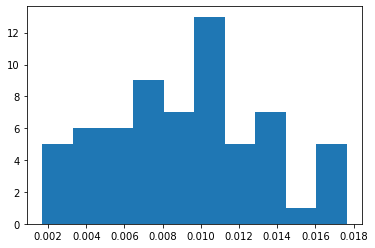

In [22]:
import matplotlib.pyplot as plt
plt.hist(abs(tf.reduce_mean(enc.layers[3].weights[0],axis=[0,1,2])))